<a href="https://colab.research.google.com/github/usernamesato/kaggle-PS-S3E7/blob/main/%5BPS_S3E7%2C_2023%5D_EDA_and_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install xgboost==1.4.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.7/166.7 MB 7.1 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
!pip install -q -U pip setuptools wheel
!pip install -q -U xgboost==1.4.2 --install-option="--gpu" --install-option="--force_cuda-10.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.
DEPRECATION: --install-option is deprecated because it forces pip to use the 'setup.py install' command which is itself deprecated. pip 23.1 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11358
DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replac

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length L{length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length L64 bytes


In [5]:
!kaggle competitions list

ref                                                                                 deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
https://www.kaggle.com/competitions/nfl-player-contact-detection                    2023-03-01 23:59:00  Featured          $100,000        913           False  
https://www.kaggle.com/competitions/asl-signs                                       2023-05-01 23:59:00  Research          $100,000          4           False  
https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting       2023-03-14 23:59:00  Featured           $60,000       2947           False  
https://www.kaggle.com/competitions/amp-parkinsons-disease-progression-prediction   2023-05-18 23:59:00  Featured           $60,000        175           False  
https://www.kaggle.com/competition

In [13]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [14]:
ls

 cloab       old/             submission_xgb_without_two_worst_ft_data_leak.csv
 cloab.pub  'PS S3 E7'/
 kaggle/     submission.csv


In [7]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import math

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [15]:
train = pd.read_csv('kaggle/input/playground-series-s3e7/train.csv').drop(columns='id')
test = pd.read_csv('kaggle/input/playground-series-s3e7/test.csv').drop(columns='id')
origin = pd.read_csv('kaggle/input/reservation-cancellation-prediction/train__dataset.csv')

In [16]:
print(f'{gld}[INFO] Shapes:'
      f'{gld}\n[+] origin -> {red}{origin.shape}'
      f'{gld}\n[+] train -> {red}{train.shape}'
      f'{gld}\n[+] test -> {red}{test.shape}\n')

print(f'{gld}[INFO] Any missing values:'
      f'{gld}\n[+] origin -> {red}{origin.isna().any().any()}'
      f'{gld}\n[+] train -> {red}{train.isna().any().any()}'
      f'{gld}\n[+] test -> {red}{test.isna().any().any()}')

[INFO] Shapes:
[+] origin -> (18137, 18)
[+] train -> (42100, 18)
[+] test -> (28068, 17)

[INFO] Any missing values:
[+] origin -> False
[+] train -> False
[+] test -> False


In [17]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
train.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .style.background_gradient(cmap='YlOrBr')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

,count,mean,std,min,25%,50%,75%,max
lead_time,42100.000000,103.888029,81.069343,0.000000,37.000000,93.000000,155.000000,443.000000
avg_price_per_room,42100.000000,104.566377,37.139165,0.000000,80.000000,99.450000,123.300000,540.000000
arrival_date,42100.000000,15.902945,8.888582,1.000000,8.000000,16.000000,24.000000,31.000000
arrival_month,42100.000000,7.593539,2.829395,1.000000,6.000000,8.000000,10.000000,12.000000
no_of_previous_bookings_not_canceled,42100.000000,0.175772,1.732121,0.000000,0.000000,0.000000,0.000000,58.000000
no_of_week_nights,42100.000000,2.398005,1.427330,0.000000,1.000000,2.000000,3.000000,17.000000
no_of_weekend_nights,42100.000000,0.884632,0.885693,0.000000,0.000000,1.000000,2.000000,7.000000
room_type_reserved,42100.000000,0.428931,0.832605,0.000000,0.000000,0.000000,1.000000,6.000000
no_of_special_requests,42100.000000,0.571734,0.775041,0.000000,0.000000,0.000000,1.000000,5.000000
market_segment_type,42100.000000,0.728504,0.633529,0.000000,0.000000,1.000000,1.000000,4.000000


In [18]:
def plot_count(df: pd.core.frame.DataFrame, col_list: list, title_name: str='Train') -> None:
    """Draws the pie and count plots for categorical variables.
    
    Args:
        df: train or test dataframes
        col_list: a list of the selected categorical variables.
        title_name: 'Train' or 'Test' (default 'Train')
        
    Returns:
        subplots of size (len(col_list), 2)
    """
    f, ax = plt.subplots(len(col_list), 2, figsize=(10, 4))
    plt.subplots_adjust(wspace=0)
    
    s1 = df[col_list].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1/N

    outer_colors = ['#9E3F00', '#eb5e00', '#ff781f', '#ff9752', '#ff9752']
    inner_colors = ['#ff6905', '#ff8838', '#ffa66b']

    ax[0].pie(
        outer_sizes,colors=outer_colors, 
        labels=s1.index.tolist(), 
        startangle=90,frame=True, radius=1.3, 
        explode=([0.05]*(N-1) + [.3]),
        wedgeprops={ 'linewidth' : 1, 'edgecolor' : 'white'}, 
        textprops={'fontsize': 12, 'weight': 'bold'}
    )

    textprops = {
        'size':13, 
        'weight': 'bold', 
        'color':'white'
    }

    ax[0].pie(
        inner_sizes, colors=inner_colors,
        radius=1, startangle=90,
        autopct='%1.f%%',explode=([.1]*(N-1) + [.3]),
        pctdistance=0.8, textprops=textprops
    )

    center_circle = plt.Circle((0,0), .68, color='black', 
                               fc='white', linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = [0, 1]
    sns.barplot(
        x=x, y=y, ax=ax[1],
        palette='YlOrBr_r', orient='horizontal'
    )

    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].tick_params(
        axis='x',         
        which='both',      
        bottom=False,      
        labelbottom=False
    )

    for i, v in enumerate(s1):
        ax[1].text(v, i+0.1, str(v), color='black', 
                     fontweight='bold', fontsize=12)

#     plt.title(col_list)
    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col_list, fontweight="bold", color='black')
    ax[1].set_ylabel('count', fontweight="bold", color='black')

    f.suptitle(f'{title_name} Dataset', fontsize=20, fontweight='bold')
    plt.tight_layout()    
#     plt.savefig('data/plot_count.png')
    plt.show()

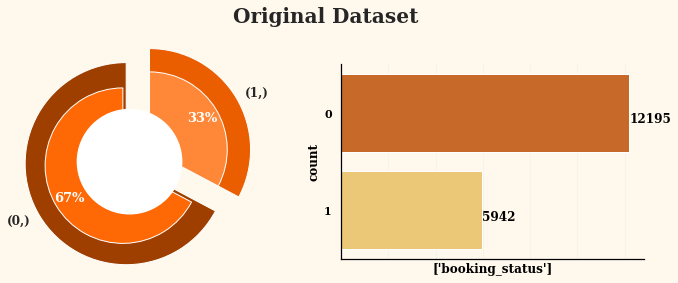

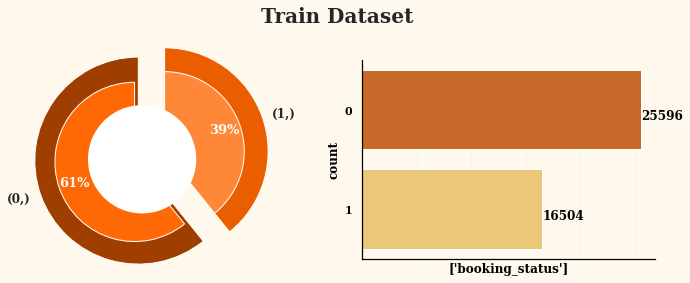

In [19]:
plot_count(origin, ['booking_status'], 'Original')
plot_count(train, ['booking_status'])

In [20]:
origin_anom = len(origin.query('arrival_year == 2018 and arrival_month == 2 and arrival_date == 29'))
train_anom = len(train.query('arrival_year == 2018 and arrival_month == 2 and arrival_date == 29'))
test_anom = len(test.query('arrival_year == 2018 and arrival_month == 2 and arrival_date == 29'))
print(f'{gld}[INFO] 2018 was not a leap year, number of Feb, 29:'
      f'{gld}\n[+] origin -> {red}{origin_anom}'
      f'{gld}\n[+] train -> {red}{train_anom}'
      f'{gld}\n[+] test -> {red}{test_anom}\n')


origin['arrival_year_month'] = pd.to_datetime(origin['arrival_year'].astype(str)
                                            +origin['arrival_month'].astype(str), format='%Y%m')
train['arrival_year_month'] = pd.to_datetime(train['arrival_year'].astype(str)
                                            +train['arrival_month'].astype(str), format='%Y%m')
test['arrival_year_month'] = pd.to_datetime(test['arrival_year'].astype(str)
                                            +test['arrival_month'].astype(str), format='%Y%m')

origin_total_anom = len(origin.loc[origin.arrival_date > origin.arrival_year_month.dt.days_in_month])
train_total_anom = len(train.loc[train.arrival_date > train.arrival_year_month.dt.days_in_month])
test_total_anom = len(test.loc[test.arrival_date > test.arrival_year_month.dt.days_in_month])
print(f'{gld}[INFO] Total date anomalies:'
      f'{gld}\n[+] origin -> {red}{origin_total_anom}'
      f'{gld}\n[+] train -> {red}{train_total_anom}'
      f'{gld}\n[+] test -> {red}{test_total_anom}\n')

train.loc[(train.arrival_date > train.arrival_year_month.dt.days_in_month) & train.arrival_month.ne(2)].head(3)

[INFO] 2018 was not a leap year, number of Feb, 29:
[+] origin -> 21
[+] train -> 35
[+] test -> 30

[INFO] Total date anomalies:
[+] origin -> 21
[+] train -> 50
[+] test -> 40



,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,arrival_year_month
4696,2,0,0,4,0,0,0,213,2018,9,31,0,0,0,0,118.15,1,1,2018-09-01
4914,2,0,2,2,0,0,0,60,2018,9,31,0,0,0,0,75.00,0,1,2018-09-01
10876,3,0,2,3,0,0,1,44,2018,4,31,1,0,0,0,131.58,0,1,2018-04-01


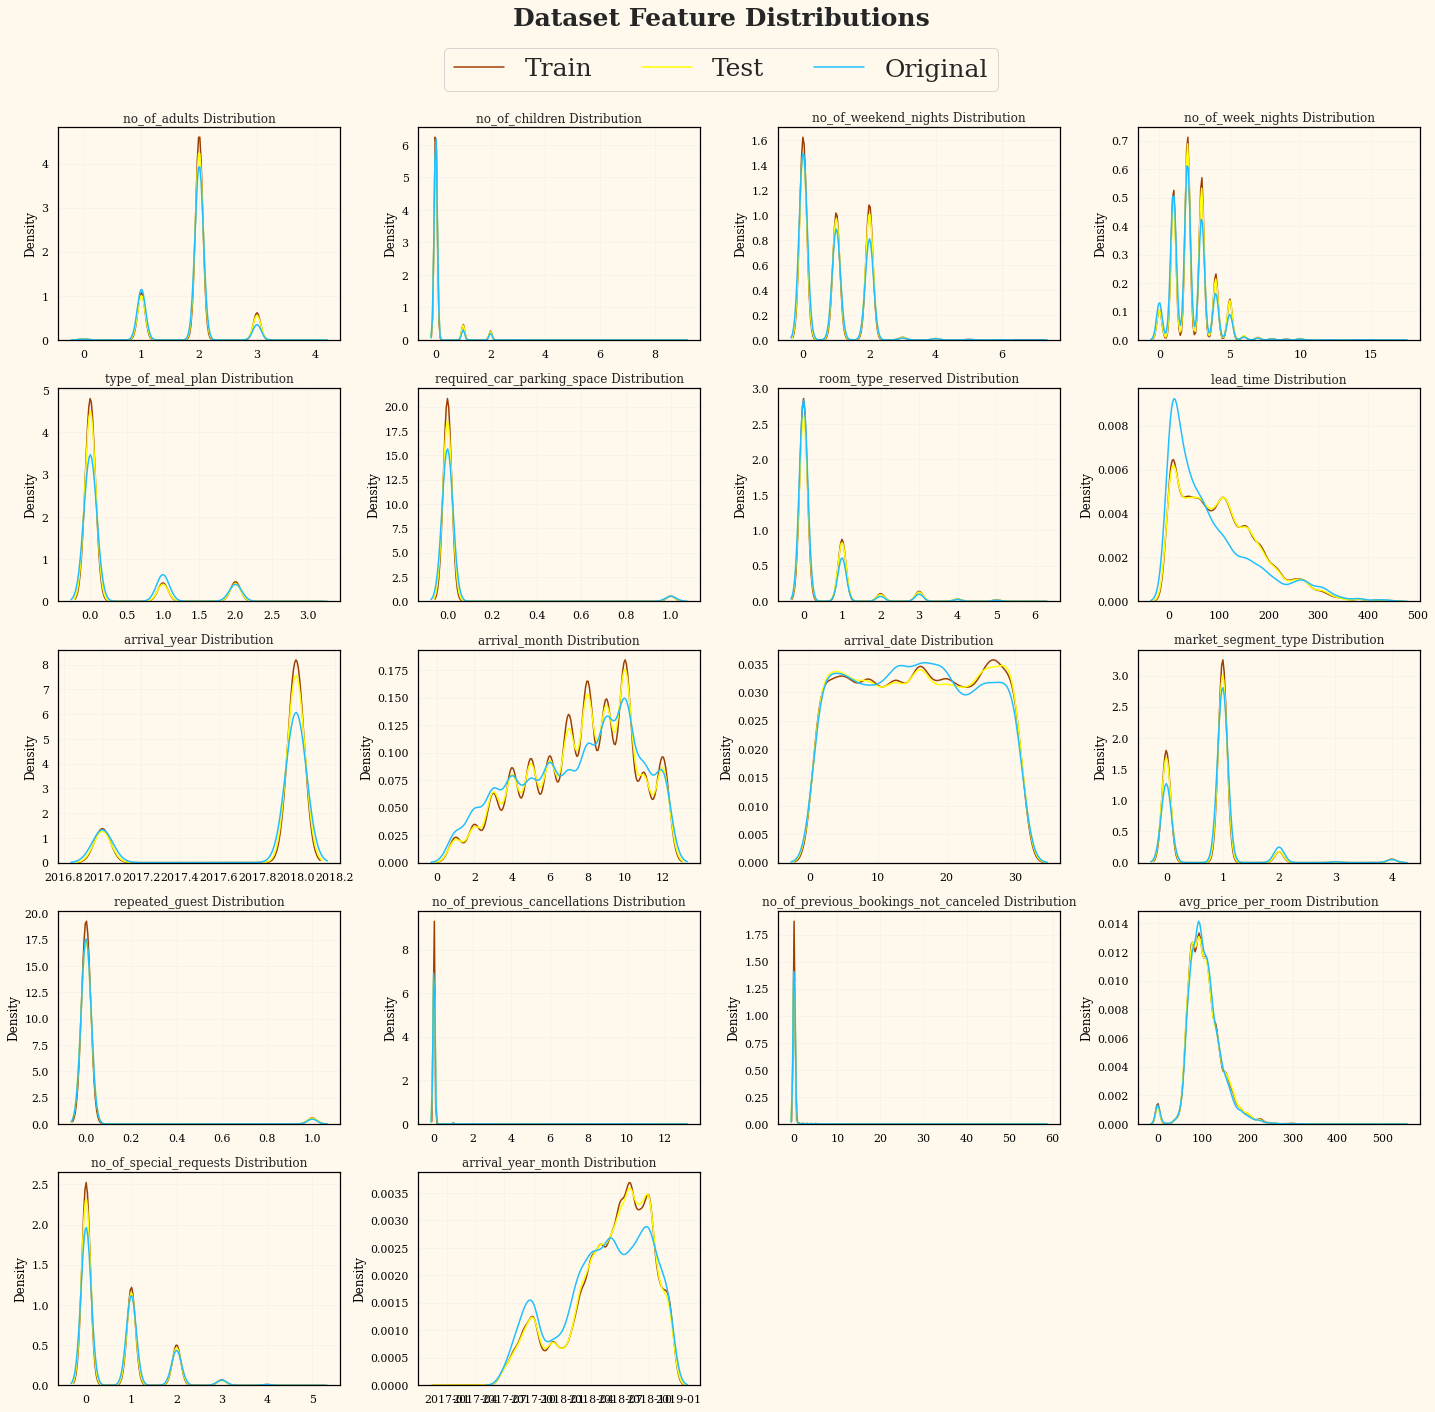

In [21]:
# kudos to @jcaliz
features = test.columns
n_bins = 50
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        train[column], label='Train',
        ax=ax[i], color='#9E3F00'
    )
    
    sns.kdeplot(
        test[column], label='Test',
        ax=ax[i], color='yellow'
    )
    
    sns.kdeplot(
        origin[column], label='Original',
        ax=ax[i], color='#20BEFF'
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()

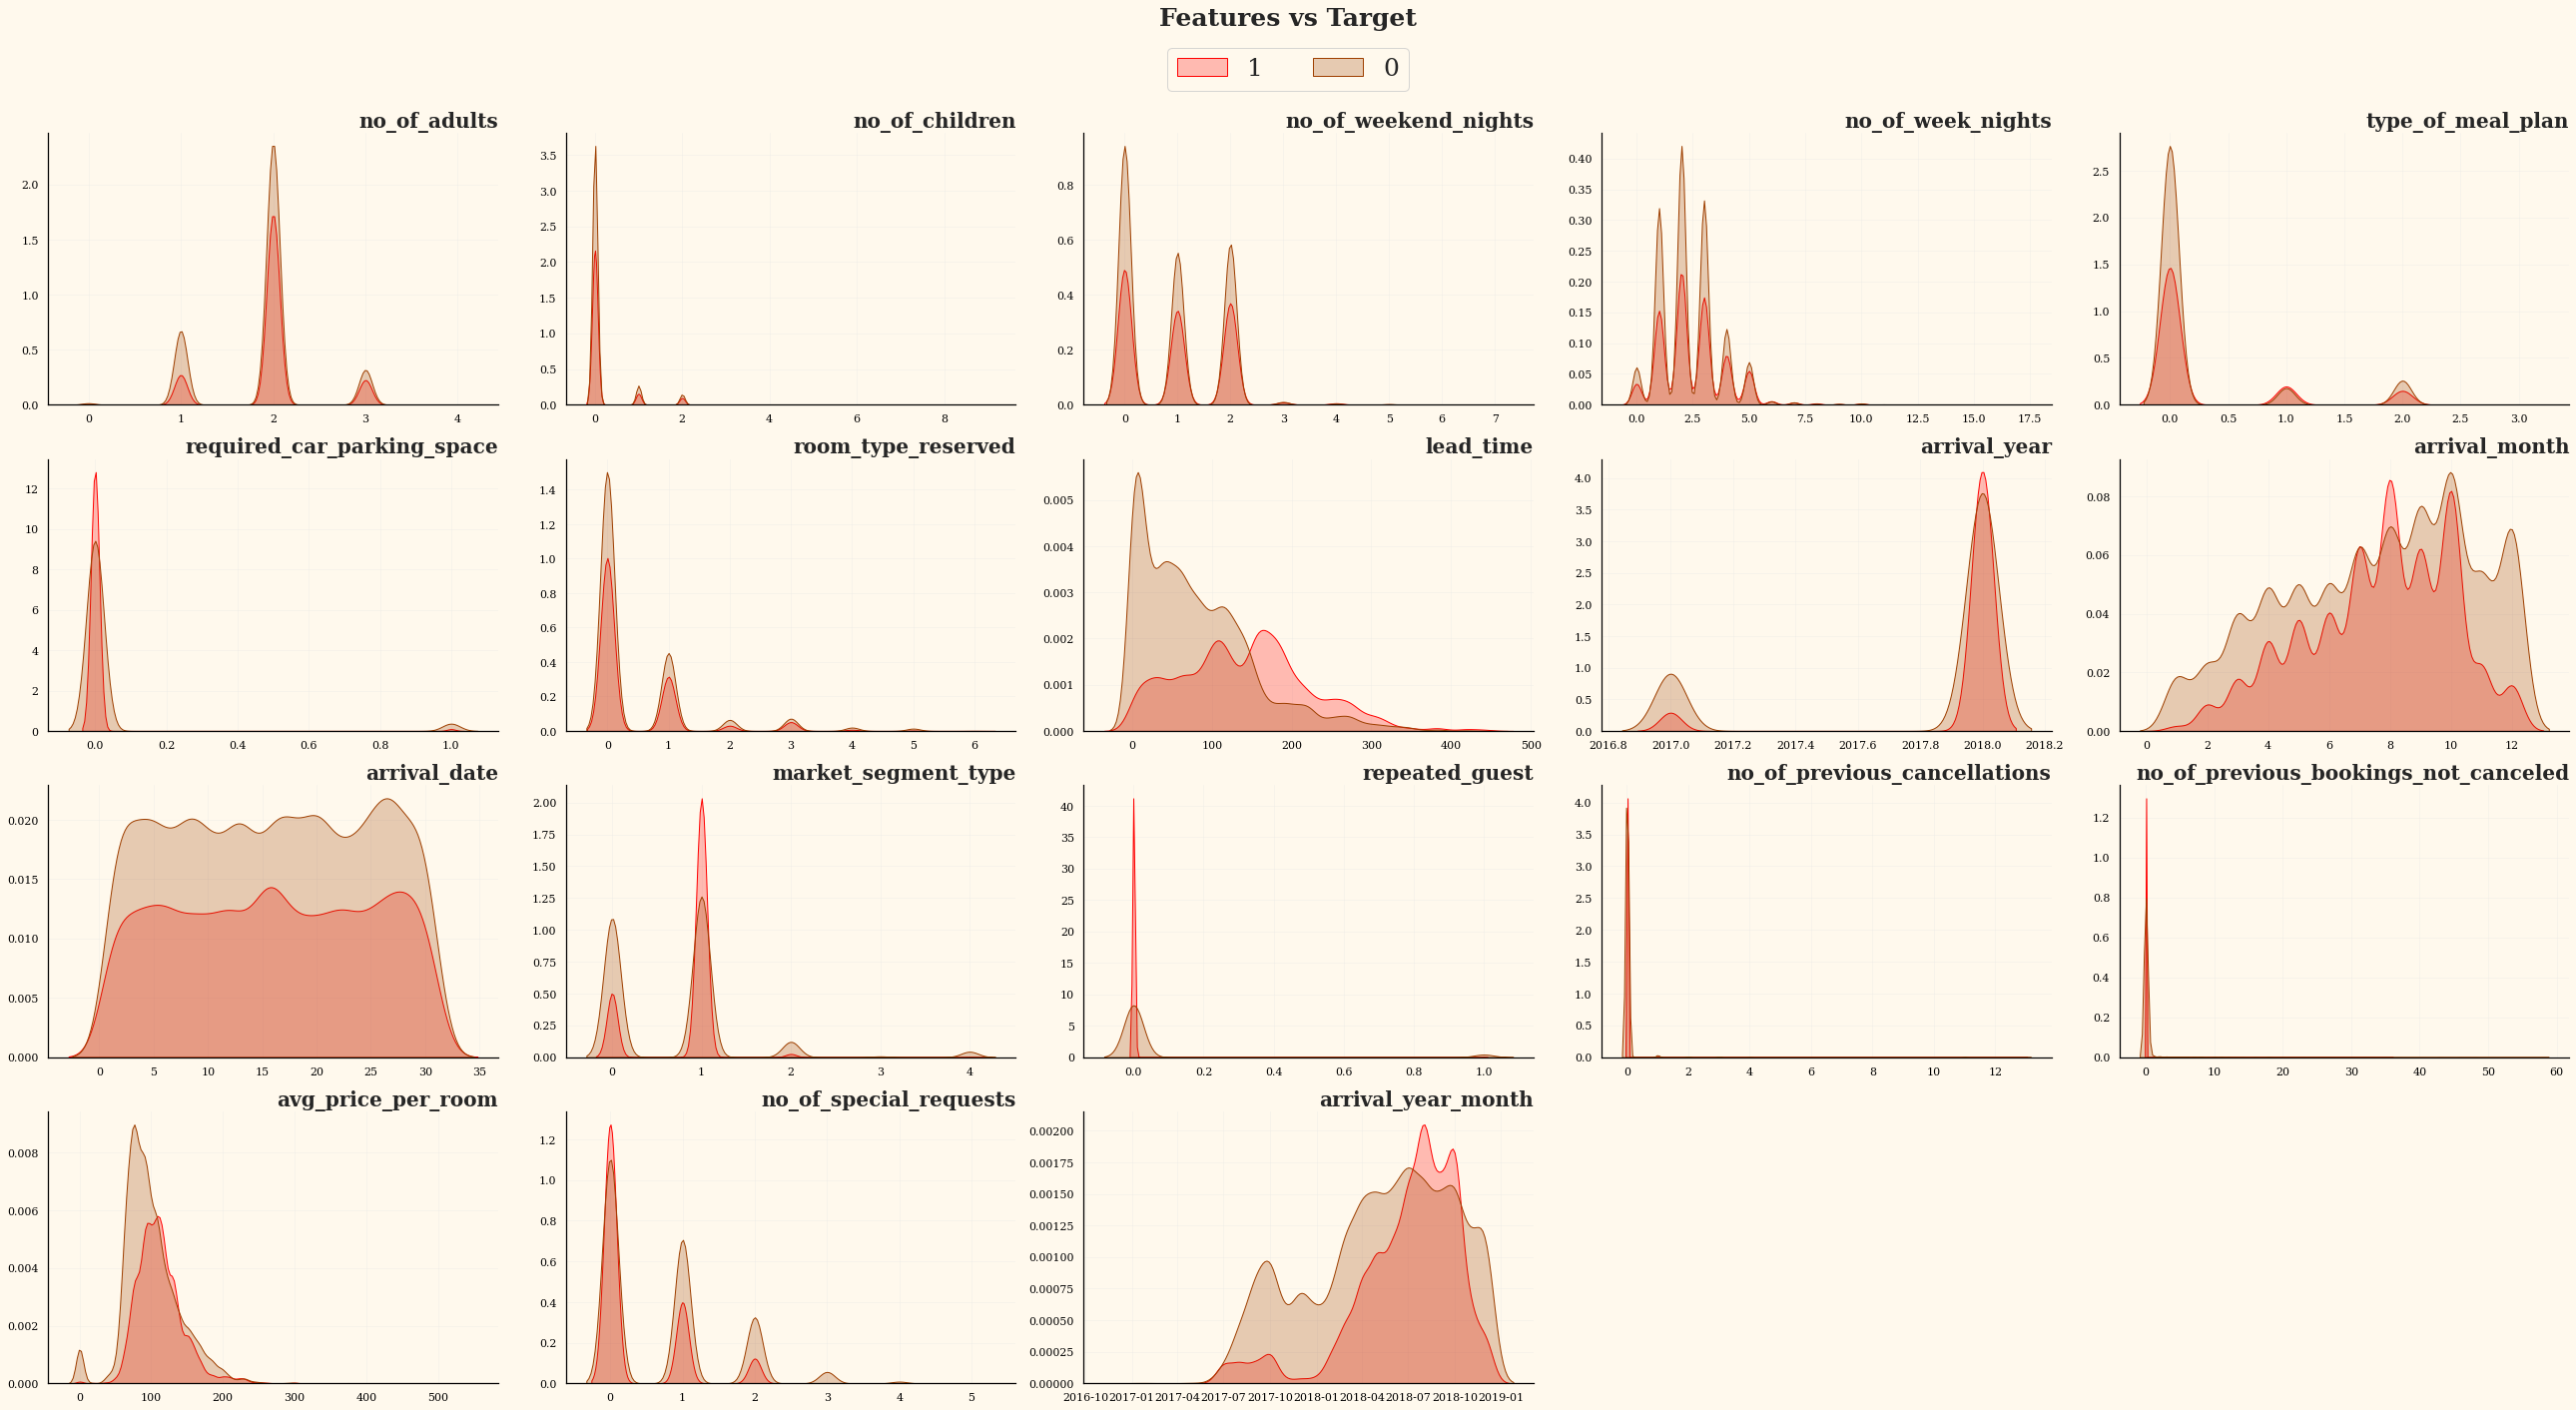

CPU times: user 8.2 s, sys: 3.75 s, total: 12 s
Wall time: 8.58 s


In [22]:
%%time
figsize = (6*6, 20)
fig = plt.figure(figsize=figsize)
for idx, col in enumerate(test.columns):
    ax = plt.subplot(4, 5, idx + 1)
    sns.kdeplot(
        data=train, hue='booking_status', fill=True,
        x=col, palette=['#9E3F00', 'red'], legend=False
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=20)

fig.suptitle(f'Features vs Target\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
plt.tight_layout()
plt.show()

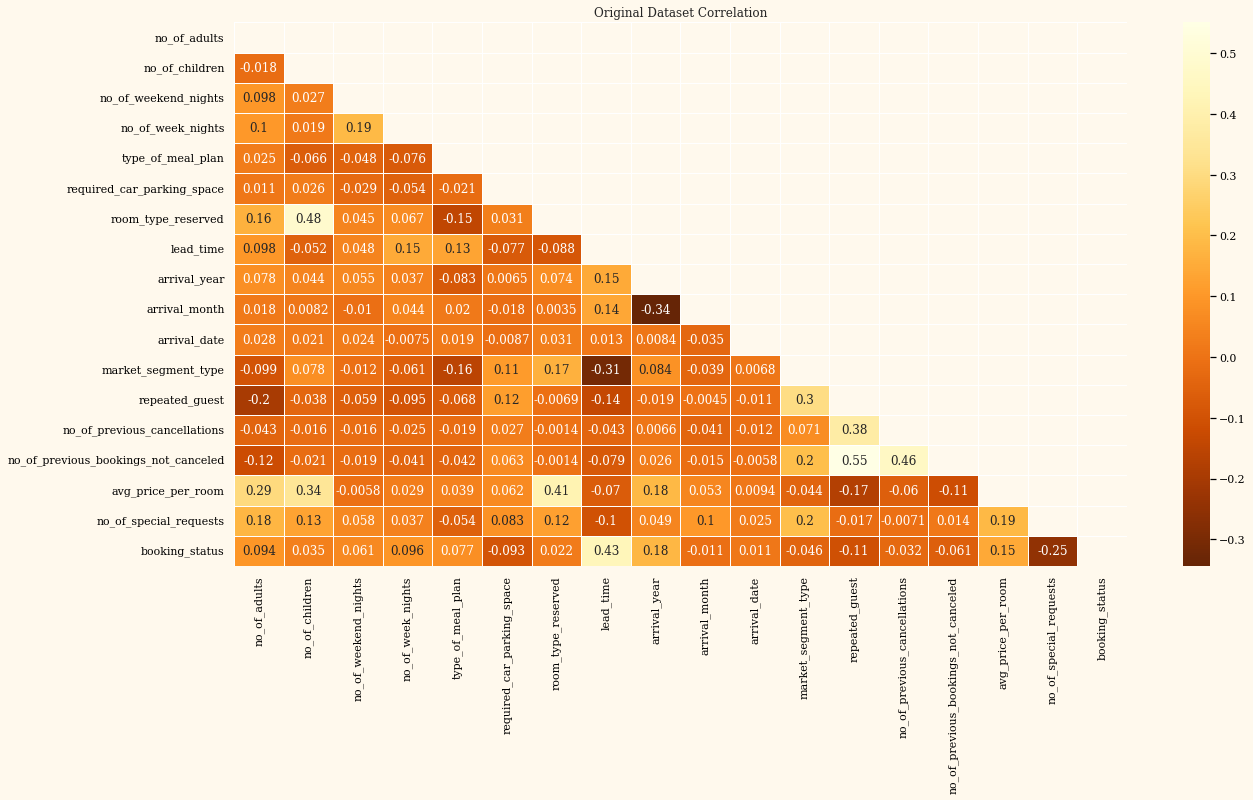

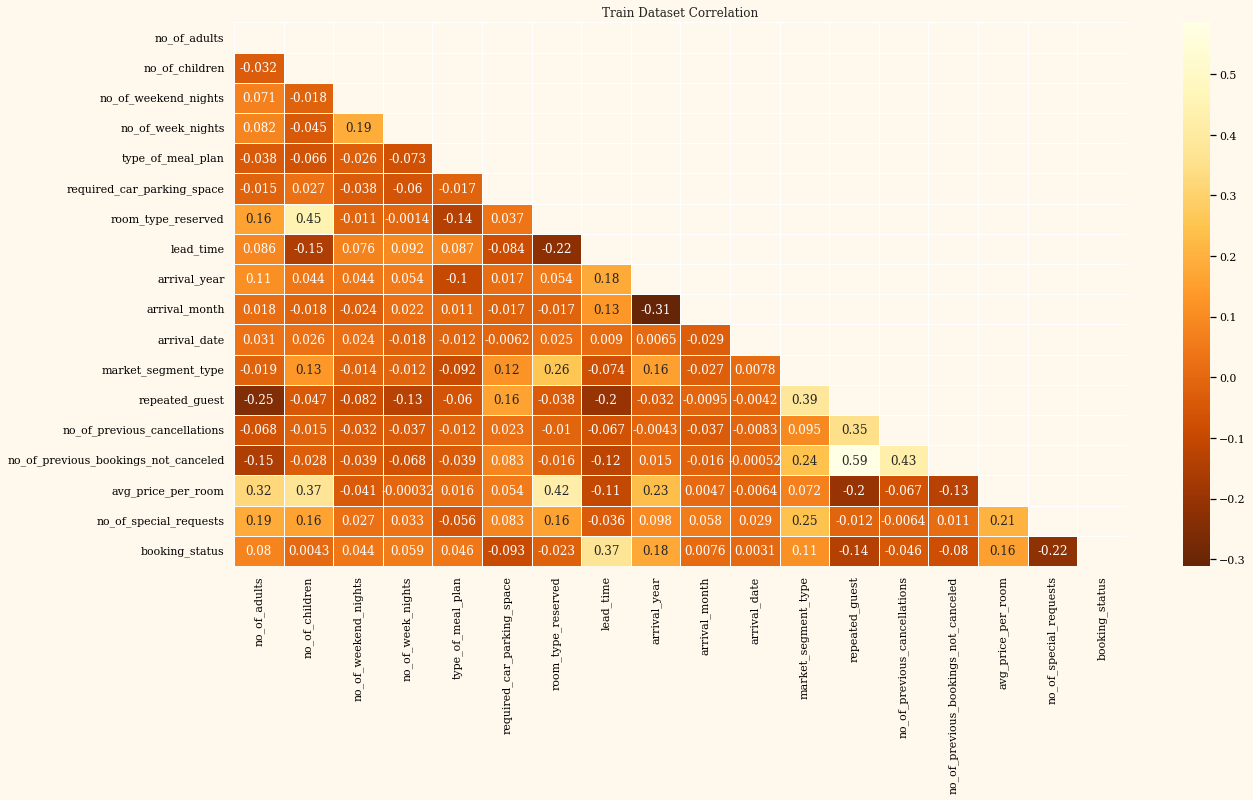

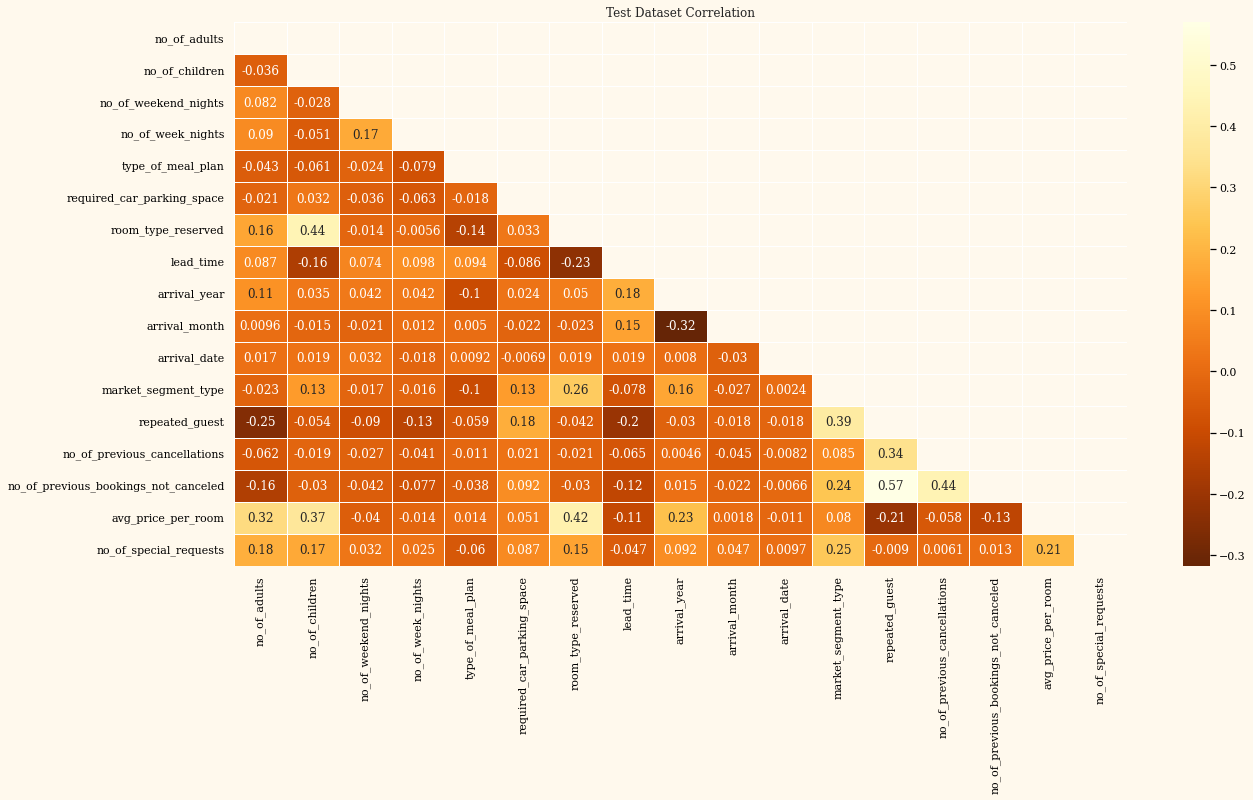

In [23]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str='Train correlation') -> None:
    """Draws the correlation heatmap plot.
    
    Args:
        df: train or test dataframes
        title_name: 'Train' or 'Test' (default 'Train correlation')
        
    Returns:
        subplots of size (len(col_list), 2)
    """

    corr = df.corr()
    fig, axes = plt.subplots(figsize=(20, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True)
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(origin, 'Original Dataset Correlation')
plot_correlation_heatmap(train, 'Train Dataset Correlation')
plot_correlation_heatmap(test, 'Test Dataset Correlation')

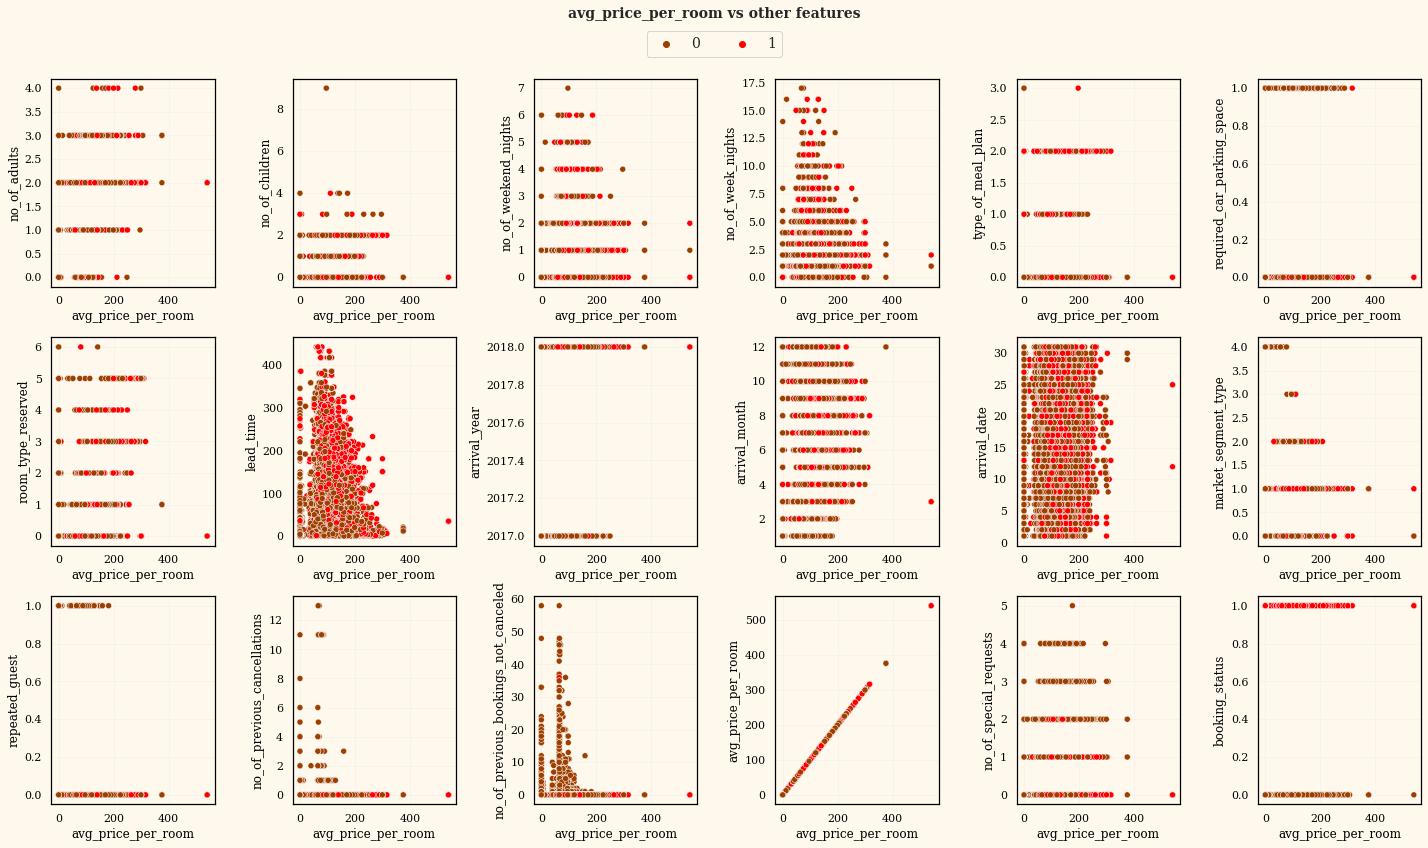

In [24]:
for col in ['avg_price_per_room']:
    fig, axes = plt.subplots(3, 6, figsize=(20, 4*3))
    for i, (ax, c) in enumerate(zip(axes.ravel(), train.columns)):
        sns.scatterplot(data=train, x=col, y=c, ax=ax, palette=['#9E3F00', 'red'],
                        hue='booking_status')
        ax.set(xlabel=col, ylabel=c)
        patches, legends = ax.get_legend_handles_labels()
        ax.legend().remove()
    fig.suptitle(f'avg_price_per_room vs other features\n\n\n', ha='center',  fontweight='bold', fontsize=14)
    fig.legend(patches, legends, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=14, ncol=2)
    plt.tight_layout()
    plt.show()

In [25]:
test.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,arrival_year_month
0,3,0,1,4,0,0,1,111,2018,12,5,1,0,0,0,115.60,2,2018-12-01
1,2,0,0,3,0,0,0,22,2017,10,21,0,0,0,0,85.00,0,2017-10-01
2,2,2,0,1,0,0,3,18,2018,8,10,1,0,0,0,240.00,1,2018-08-01
3,2,0,0,3,0,0,0,88,2018,5,30,0,0,0,0,80.75,0,2018-05-01
4,1,0,0,2,2,0,0,7,2018,9,21,1,0,0,0,144.00,0,2018-09-01


In [26]:
train = pd.read_csv('kaggle/input/playground-series-s3e7/train.csv').drop(columns='id')
test = pd.read_csv('kaggle/input/playground-series-s3e7/test.csv').drop(columns='id')
origin = pd.read_csv('kaggle/input/reservation-cancellation-prediction/train__dataset.csv')

In [27]:
%%time
#############################################################################################
# CFG
#############################################################################################
SEED = 42
FOLDS = 30
ALPHA = 7
EXP_NUM = 1
SAVE = False
COMBINE = True

if COMBINE:
    train = pd.concat([train, origin]).reset_index(drop=True)
    
class BookingDataProcessor:
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
    
    @staticmethod
    def fe(df):
        # Fix date anomalies (pd.to_datetime throws parsing error for some days, see anomalies section).
        df['year_month'] = pd.to_datetime(df[['arrival_year', 'arrival_month']].astype(str).sum(1), format='%Y%m')
        df.loc[df.arrival_date > df.year_month.dt.days_in_month, 'arrival_date'] = df.year_month.dt.days_in_month
        df.drop(columns='year_month', inplace=True)
        
#         # Creates date features.
#         df['arrival_full_date'] = (df['arrival_year'].astype(str) 
#                                    + '-' + df['arrival_month'].astype(str)
#                                    + '-' + df['arrival_date'].astype(str))
#         df['arrival_full_date'] = pd.to_datetime(df.arrival_full_date)
#         df['arrival_week'] = df['arrival_full_date'].dt.isocalendar().week.astype(float)
#         df['arrival_dayofweek'] = df['arrival_full_date'].dt.dayofweek
#         df['arrival_quarter'] = df['arrival_full_date'].dt.quarter
#         df['arrival_dayofyear'] = df['arrival_full_date'].dt.dayofyear
        
#         # Creates the season and holiday features. (also you can add holidays).
#         # ['winter', 'spring', 'summer', 'fall']
#         df['season'] = df.arrival_month%12 // 3 + 1
#         cal = USFederalHolidayCalendar()
#         holidays = cal.holidays(start='2017-01-01', end='2018-12-31')
#         df['is_holiday'] = 0
#         df.loc[df.arrival_full_date.isin(holidays), 'is_holiday'] = 1
        
#         # Aggregation by `season` as key and 'avg_price_per_room' as value (you can try quarters, months, etc).
#         aggr_df = df.groupby(by=key, sort=False)['avg_price_per_room'].agg(['mean', 'std', 'min', 'max', 'sum', 'last'])
#         aggr_df = aggr_df.add_prefix('avg_price_per_room_')
#         df = df.merge(aggr_df.reset_index(), on=key, how='left')
        
#         # Interaction between the correlated features and also lead time.
#         df['no_of_adults_div_price'] = df.no_of_adults / (df.avg_price_per_room + 1e-6)
#         df['no_of_children_div_price'] = df.no_of_children / (df.avg_price_per_room + 1e-6)
#         df['lead_time_div_price'] = df.lead_time / (df.avg_price_per_room + 1e-6)
#         df.drop(columns=['arrival_full_date'], inplace=True)
        return df

    def process_data(self):
        self.train_data = self.fe(self.train_data)
        self.test_data = self.fe(self.test_data)
        return self.train_data, self.test_data
    
f_e = BookingDataProcessor(train, test)
train, test = f_e.process_data()        

print(f'{gld}[INFO] Shapes after Feature Engineering Phase:'
      f'{gld}\n[+] train -> {red}{train.shape}'
      f'{gld}\n[+] test -> {red}{test.shape}\n')

[INFO] Shapes after Feature Engineering Phase:
[+] train -> (60237, 18)
[+] test -> (28068, 17)

CPU times: user 168 ms, sys: 6.51 ms, total: 174 ms
Wall time: 173 ms


In [28]:
def f_importance_plot(f_imp):
  fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
  plt.title('Feature importances', size=16, y=1.05,
            fontweight='bold', color='#444444')
  a = sns.barplot(data=f_imp, x='avg_imp', y='feature',
                  palette='YlOrBr_r', linestyle='-',
                  linewidth=0.5, edgecolor='black')
  plt.xlabel('')
  plt.xlabel([])
  plt.ylabel('')
  plt.yticks(size=11, color='#444444')

  for j in ['right', 'top', 'bottom']:
    a.spines[j].set_visible(False) #chatGPT参照
  for j in ['left']:
    a.spines[j].set_linewidth(0.5)
  plt.tight_layout()
  plt.show()

def show_confusion_roc(oof: list) -> None:
  """Draws a confusion matrix and roc_curve with AUC score.
        
        Args:
            oof: predictions for each fold stacked. (list of tuples)
        
        Returns:
            None
  """
  f, ax = plt.subplots(1, 2, figsize=(13,3, 4))
  df = pd.DateFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
  df.index = df.index.astype(int)
  cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
  cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r', ax=ax[0]) #chatGPT参照
  ax[0].grid(False)
  RocCurveDisplay.from_prediction(df.target, df.preds, color='#20BEFF', ax=ax[1])
  plt.tight_layout();

def get_mean_auc(oof: np.array):
  """oof: ['val_idx', 'preds', 'target']"""
  oof = pd.DataFrame(np.concatenate(oof), columns=['id', 'preds', 'target']).set_index('id')
  oof.index = oof.index.astype(int)
  mean_val_auc = roc_auc_score(oof.target, oof.preds)
  return mean_val_auc

In [29]:
%%time

xgb_models = []
xgb_oof = []
predictions = np.zeros(len(test))
f_imp = []

counter = 1
X = train.drop(columns=['booking_status'] + ['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled'])
y = train.booking_status
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
  if (fold + 1)%5 == 0  or (fold + 1) == 1:
    print(f'{"#"*24} Training FOLD {fold+1} {"#"*24}')

  X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
  X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]
  watchlist = [(X_train, y_train), (X_valid, y_valid)]

  #XGboost model and fit
  model = XGBClassifier(tree_method ='gpu_hist', n_estimators=2000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67, objective='binary:logistic', eval_metric='logloss')
  model.fit(X_train, y_train, eval_set=watchlist, early_stopping_rounds=300, verbose=0)

  val_preds = model.predict_proba(X_valid)[:, 1]
  val_score = roc_auc_score(y_valid, val_preds)
  best_iter = model.best_iteration

  idx_pred_target = np.vstack([val_idx, val_preds, y_valid]).T # shape(len(val_idx), 3)
  f_imp.append({i: j for i in model.get_booster().feature_names for j in model.feature_importances_ })
  print(f'{" "*20} auc:{blu}{val_score:.5f}{res} {" "*6} best iteraton :{blu}{best_iter}{res}')

  xgb_oof.append(idx_pred_target)
  xgb_models.append(model)
#     test_preds = model.predict_proba(test)[:,1] / FOLDS
#     predictions += test_preds
  if val_score > 0.917:
    test_preds = model.predict_proba(test.drop(columns=['no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled']))[:, 1]
    predictions += test_preds
    counter += 1

predictions /= counter
mean_val_auc = get_mean_auc(xgb_oof)
print('*'*45)
print(f'{red}Mean{res} AUC: {red}{mean_val_auc:.5f}{res}')


######################## Training FOLD 1 ########################
                     auc:0.91926        best iteraton :864
                     auc:0.92441        best iteraton :808
                     auc:0.91475        best iteraton :704
                     auc:0.91905        best iteraton :772
######################## Training FOLD 5 ########################
                     auc:0.90961        best iteraton :589
                     auc:0.90527        best iteraton :749
                     auc:0.91288        best iteraton :740
                     auc:0.90953        best iteraton :378
                     auc:0.90613        best iteraton :571
######################## Training FOLD 10 ########################
                     auc:0.91434        best iteraton :596
                     auc:0.92008        best iteraton :748
                     auc:0.91280        best iteraton :686
                     auc:0.90169        best iteraton :878
                     auc:0.91291  

In [30]:
np.array((xgb_oof)).shape

(30,)

In [31]:
#show_confusion_roc(xgb_oof)
f_imp_df = pd.DataFrame(f_imp).mean().reset_index()
f_imp_df.columns = ['feature', 'avg_imp']
f_importance_plot(f_imp_df)

TypeError: ignored

In [ ]:
sns.histplot(predictions, color='#20BEFF');
print(predictions.min(), predictions.max())
sub = pd.read_csv('kaggle/input/playground-series-s3e7/sample_submission.csv')
# sub_lgbm = pd.read_csv('/kaggle/input/s3e7-submissions/lgbm_base_no_threshold.csv')
# sub.booking_status = predictions * .51 + sub_lgbm.booking_status/10 * .49
# sub.to_csv('submission_blend_with_lgbm.csv', index=False)
sub.booking_status = predictions
sub.to_csv('submission.csv', index=False)
sub.head(3)

In [ ]:
!kaggle competitions submit -c playground-series-s3e7 -f submission.csv -m "submit message"

In [ ]:
train = pd.read_csv('kaggle/input/playground-series-s3e7/train.csv')
test = pd.read_csv('kaggle/input/playground-series-s3e7/test.csv')

y = 'booking_status'
dup_features = test.drop(columns='id').columns.tolist()
values_to_assign = test.merge(train.drop(columns='id'), on=dup_features, how='inner')[['id', y]]
map_di = {0: sub[y].max(), 1: sub[y].min()}
sub.loc[sub.id.isin(values_to_assign.id), y] = values_to_assign[y].map(map_di).values
sub.loc[sub.id.isin(values_to_assign.id), y]

sub.to_csv('submission_xgb_without_two_worst_ft_data_leak.csv', index=False)
sub.loc[sub.id.isin(values_to_assign.id)].head(10)

In [ ]:
predictions

In [ ]:
counter